# EDA and data info extraction

## Import modules

In [1]:
import sys
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

# cyberpunk theme
import mplcyberpunk
plt.style.use('cyberpunk')


import cv2 as cv

from sklearn.model_selection import train_test_split

# project-specific custom functions
## export the path to custom modules
sys.path.append("../functions")
## import functions
from preprocessing import import_image_files, import_images_from_file_list


## Data loading and preprocessing

- loading
- splitting

### Load the data and construct info DataFrames

- start with the available data information in the "train_features.csv" file
- load the images from the given list
- append information about images
  - shape
  - height
  - width
  - number of channels
  - label value
  - nominal category (...)

In [2]:
# read feature and label information into a DataFrame

dir_data_relative = "../data/"  # the relative directory path to all data files

In [3]:
## feature information
### for the purposes of this project, the data listed in "train_features.csv" represents all data available
df__data_info = pd.read_csv(dir_data_relative+"train_features.csv")
df__data_info.head(2)

,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069


In [4]:
### label information
df__labels = pd.read_csv(dir_data_relative+"train_labels.csv")
df__labels.head(2)

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
## load all info data (one numpy array per image). use the list from the DataFrame to get a matching order
filepaths = (dir_data_relative + df__data_info.filepath).to_list()  # list with all image file paths
image_list = import_images_from_file_list(file_list=filepaths)  # load all images

In [6]:
# calculate useful information about all images

## get the image shapes
shape_Series = pd.Series([image.shape for image in image_list], name="shape")  # all shapes

## extract individual shape values
shapes_DataFrame = pd.DataFrame(shape_Series.to_list(), columns=["height", "width", "N_channels"])

## calculate the image dimension ratios
ratio_Series = pd.Series([x/y for (y, x, _) in shape_Series], name="aspect_ratio")

## label values

## nominal class values


## join everything with the original info DataFrame
df__data_info = pd.concat(objs=[df__data_info, shape_Series, shapes_DataFrame, ratio_Series], axis=1)
df__data_info.head(3)

,id,filepath,site,shape,height,width,N_channels,aspect_ratio
0,ZJ000000,train_features/ZJ000000.jpg,S0120,"(540, 960, 3)",540,960,3,1.777778
1,ZJ000001,train_features/ZJ000001.jpg,S0069,"(540, 960, 3)",540,960,3,1.777778
2,ZJ000002,train_features/ZJ000002.jpg,S0009,"(360, 640, 3)",360,640,3,1.777778


In [7]:
# join the label data


## check if the label only contains a single class per image
animal_in_scene = df__labels.drop(columns="id")  # one-hot-encoded label
animal_in_scene.sum(axis=1).value_counts()  # check for unique values

1.0    16488
Name: count, dtype: int64

In [8]:
## since there is only one animal label per scene and no dropping of dummy variables is present here,
## one can use inverse one-hot-encoding to get the actual animal names as labels
animal_label = pd.from_dummies(animal_in_scene.astype(int))[""]
animal_label.name = "animal_label"
# animal_label.columns = ["1", "2"]
animal_label.head(3)

0                bird
1    monkey_prosimian
2                bird
Name: animal_label, dtype: object

In [9]:
## extend the label data by a list of animals in the scence
df__labels = pd.concat(objs=[animal_label, df__labels], axis=1)
df__labels.head()

,animal_label,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,bird,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,monkey_prosimian,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,bird,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,monkey_prosimian,ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,leopard,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
(df__data_info.id == df__labels.id).unique()

array([ True])

In [11]:
## join the frames (use the merge method to join on a column instead of the index of the frame provided as an argument)
df__data_info_all = df__data_info.merge(right=df__labels, on="id", how="left")
df__data_info_all.head()

,id,filepath,site,shape,height,width,N_channels,aspect_ratio,animal_label,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,train_features/ZJ000000.jpg,S0120,"(540, 960, 3)",540,960,3,1.777778,bird,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,train_features/ZJ000001.jpg,S0069,"(540, 960, 3)",540,960,3,1.777778,monkey_prosimian,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,train_features/ZJ000002.jpg,S0009,"(360, 640, 3)",360,640,3,1.777778,bird,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000003,train_features/ZJ000003.jpg,S0008,"(360, 640, 3)",360,640,3,1.777778,monkey_prosimian,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ZJ000004,train_features/ZJ000004.jpg,S0036,"(335, 640, 3)",335,640,3,1.910448,leopard,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
# save the constructed DataFrame
df__data_info_all.to_csv(dir_data_relative+"data_info__all.csv", index=False)

# EDA

- check if there are multiple animals in a single scene. If so, check if they are different or of the same species.
  - count the number of list items in the label list column
- check the image shape distribution

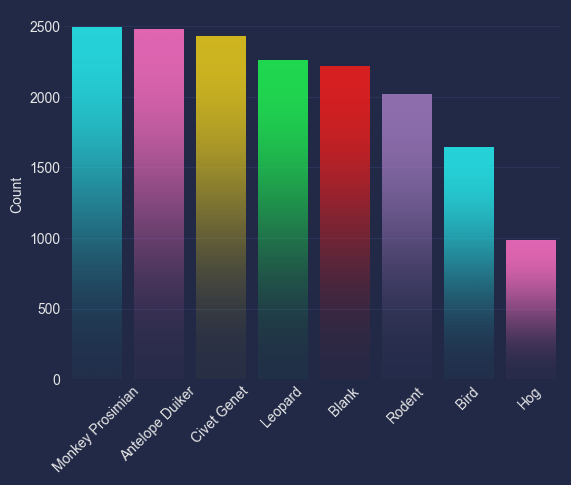

In [13]:
colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"]
order = df__data_info_all["animal_label"].value_counts().index
x_tick_labels = order.str.title().str.replace("_", " ")

fig, ax = plt.subplots(1, 1)
sns.countplot(data=df__data_info_all,
              x="animal_label",
              # stat="percent",
              order = order,
              palette=colors,
              ax=ax)
ax.set(xlabel="",#"Animal",
       ylabel="Count")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticklabels(x_tick_labels)
mplcyberpunk.add_bar_gradient(bars=ax.containers[0])

In [14]:
ax.containers[0]

<BarContainer object of 8 artists>

shape
(360, 640, 3)    7490
(540, 960, 3)    6345
(335, 640, 3)     970
(240, 360, 3)     864
(515, 960, 3)     458
(120, 160, 3)     293
(215, 360, 3)      67
(95, 160, 3)        1
Name: count, dtype: int64


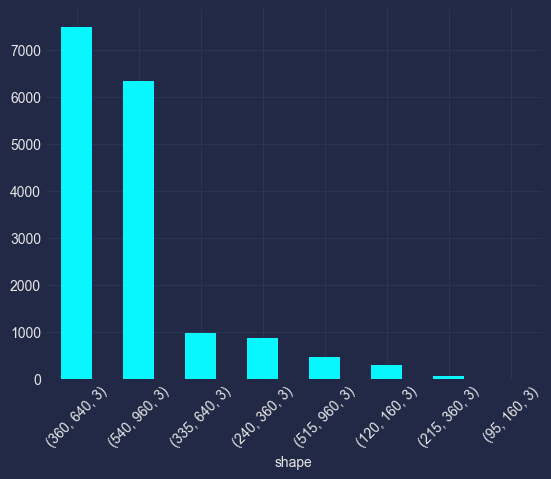

In [15]:
# check the image shape distribution

print(df__data_info["shape"].value_counts())

ax = df__data_info["shape"].value_counts().plot(kind="bar")
ax.tick_params(axis='x', labelrotation=45)

In [16]:
# dirty interrupt of full notebook execution

asdfsadfds

NameError: name 'asdfsadfds' is not defined

# Split the data (old method without considering disjoint datasets with respect to the sites -- i.e. not used anymore)

- split the data list (80% train, 10% dev, 10% test), stratify according to label column
- store the individual dataset

In [ ]:
y = df__labels.iloc[:, 2:]
# split off test set
X_train__info, X_test__info, y_train, y_test = train_test_split(df__data_info, y, test_size=0.1, stratify=y)

# split off validation set
X_train__info, X_val__info, y_train, y_val = train_test_split(X_train__info, y_train, test_size=1/9, stratify=y_train)

In [ ]:
print(f"train data info shape: {X_train__info.shape}")
print(f"val data info shape: {X_val__info.shape}")
print(f"test data info shape: {X_test__info.shape}")

train data info shape: (13190, 8)
val data info shape: (1649, 8)
test data info shape: (1649, 8)


In [ ]:
# save the data info files

X_train__info.to_csv(dir_data_relative+"X_train__info.csv", index=False)
X_val__info.to_csv(dir_data_relative+"X_val__info.csv", index=False)
X_test__info.to_csv(dir_data_relative+"X_test__info.csv", index=False)

y_train.to_csv(dir_data_relative+"y_train.csv", index=False)
y_val.to_csv(dir_data_relative+"y_val.csv", index=False)
y_test.to_csv(dir_data_relative+"y_test.csv", index=False)

# Old stuff (REFACTOR)

- [ ] Get the minmum of all shapes (in each dimensions)
        - 95, 160
- [ ] maybe convert all to greyscale?
- [ ] crop the images by indexing in the first two dimensions
- [ ] flatten the arrays

Current goal:
- [ ] check if there are only two shapes for each site
- [ ] check if all shapes for each site only differ by the first dimension (and in 25 pixels)

In [ ]:
df_train_features.groupby("site").value_counts().reset_index()

NameError: name 'df_train_features' is not defined

In [ ]:
n_shapes = []
site_info = {"site":[], "n_shapes_unique":[], "n_images":[]}  # intitializa site info dict

for site in sites:  # iterate over all sites

    paths_temp = "../data/" + df_train_features[df_train_features["site"] == site]["filepath"]  # select all rows with this site, select the filepath column and add the directory hierarchy

    images_temp = import_images_from_file_list(paths_temp.to_list())  # read all images for the current site

    n_images_temp = len(images_temp)

    shapes_temp = [image.shape for image in images_temp]
    shapes_temp_unique = pd.Series(shapes_temp).unique()
    n_shapes_temp_unique = shapes_temp_unique.shape[0]

    site_info["site"].append(site)
    site_info["n_shapes_unique"].append(n_shapes_temp_unique)
    site_info["n_images"].append(n_images_temp)
    # print(f"site: {site}")
    # print(f"shapes: {shapes_temp_unique}")
    # print(f"number of unique shapes: {n_shapes_temp_unique}")

site_info = pd.DataFrame(site_info)
site_info

,site,n_shapes_unique,n_images
0,S0120,2,423
1,S0069,1,217
2,S0009,2,664
3,S0008,2,541
4,S0036,2,456
...,...,...,...
143,S0079,1,2
144,S0178,1,2
145,S0148,1,7
146,S0006,2,16


In [ ]:
# How many sites pre unique shape number are there?
site_info.n_shapes_unique.value_counts().reset_index()

,n_shapes_unique,count
0,1,84
1,2,59
2,3,5


In [ ]:
# how many images per unique shape are there?
site_info.groupby(by="n_shapes_unique")["n_images"].sum().reset_index()

,n_shapes_unique,n_images
0,1,5321
1,2,10838
2,3,329


In [ ]:
# for the sites with only 2 unique shapes, what shape differences are there?
sites__2_shapes = site_info[site_info["n_shapes_unique"]==2]["site"].to_list()  # select all sites with 2 unique image shapes

df_train_features__2_shapes = df_train_features.query("site in @sites__2_shapes")  # select all data entries with 2 unique shapes
df_train_features__2_shapes

,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000003,train_features/ZJ000003.jpg,S0008
4,ZJ000004,train_features/ZJ000004.jpg,S0036
6,ZJ000006,train_features/ZJ000006.jpg,S0060
...,...,...,...
16480,ZJ016480,train_features/ZJ016480.jpg,S0179
16481,ZJ016481,train_features/ZJ016481.jpg,S0127
16483,ZJ016483,train_features/ZJ016483.jpg,S0093
16484,ZJ016484,train_features/ZJ016484.jpg,S0043


In [ ]:
# iterate over the selected sites with 2 unique image shapes and get the shape differences in form of tuples
## thereafter 

for site in sites:  # iterate over all sites

    paths_temp = "../data/" + df_train_features[df_train_features["site"] == site]["filepath"]  # select all rows with this site, select the filepath column and add the directory hierarchy

    images_temp = import_images_from_file_list(paths_temp.to_list())  # read all images for the current site

    n_images_temp = len(images_temp)

    shapes_temp = [image.shape for image in images_temp]
    shapes_temp_unique = pd.Series(shapes_temp).unique()
    n_shapes_temp_unique = shapes_temp_unique.shape[0]

    site_info["site"].append(site)
    site_info["n_shapes_unique"].append(n_shapes_temp_unique)
    site_info["n_images"].append(n_images_temp)
    # print(f"site: {site}")
    # print(f"shapes: {shapes_temp_unique}")
    # print(f"number of unique shapes: {n_shapes_temp_unique}")

AttributeError: 'Series' object has no attribute 'append'

### Checking the image with outlier shape

In [ ]:
df_train_features_extended[df_train_features_extended["shape"]==(95, 160, 3)]

,id,filepath,site,shape
2282,ZJ002282,train_features/ZJ002282.jpg,S0080,"(95, 160, 3)"


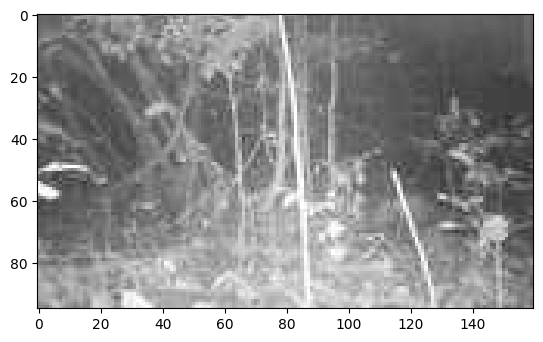

In [ ]:
plt.imshow(import_images_from_file_list(["../data/train_features/ZJ002282.jpg"])[0])